In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("../full_variants/blood.traits.gwas.benchmarking.all.tsv", sep="\t", header=0)

/users/anusri/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.columns

Index(['var.chr', 'var.pos_hg38', 'var.allele1', 'var.allele3', 'obs.maxPIP',
       'pred.chrombpnet.encsr637xsc.varscore.logfc',
       'pred.chrombpnet.encsr637xsc.varscore.jsd',
       'pred.chrombpnet.encsr637xsc.varscore.ips',
       'pred.chrombpnet.encsr637xsc.varscore.ips.pval',
       'pred.chrombpnet.encsr000emt.varscore.logfc',
       'pred.chrombpnet.encsr000emt.varscore.jsd',
       'pred.chrombpnet.encsr000emt.varscore.ips',
       'pred.chrombpnet.encsr000emt.varscore.ips.pval', 'var.rsid',
       'obs.traits', 'var.IDs', 'var.variant_id'],
      dtype='object')

In [4]:
data.head(2)

,var.chr,var.pos_hg38,var.allele1,var.allele3,obs.maxPIP,pred.chrombpnet.encsr637xsc.varscore.logfc,pred.chrombpnet.encsr637xsc.varscore.jsd,pred.chrombpnet.encsr637xsc.varscore.ips,pred.chrombpnet.encsr637xsc.varscore.ips.pval,pred.chrombpnet.encsr000emt.varscore.logfc,pred.chrombpnet.encsr000emt.varscore.jsd,pred.chrombpnet.encsr000emt.varscore.ips,pred.chrombpnet.encsr000emt.varscore.ips.pval,var.rsid,obs.traits,var.IDs,var.variant_id
0,chr1,10352,T,TA,NaN,-0.036835,-0.016749,0.000497,0.055084,0.004799,0.013399,0.000059,0.219019,NaN,NaN,NaN,rs150218945
1,chr1,11012,C,G,NaN,-0.010156,-0.022090,0.000218,0.116639,0.008337,0.031942,0.000489,0.061075,NaN,NaN,NaN,rs544419019


In [5]:
import matplotlib


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 10]

def plot_enrichment_curves(df, compare_score, model_score, output_file, compare_score_ascending=False, model_score_ascending=True,
                           thresh_list=[0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], subsample=False, ymax='auto', debug=False):
    by_thresh_dict = {'score':[], 'ratio':[], 'thresh':[]}
    
    for thresh in thresh_list:
        df[compare_score].fillna(0, inplace=True)
        sample_df = df.sort_values(by=[compare_score, model_score], ascending=[False, True])
        #print(sample_df.head())
        #print(sample_df.tail())
        print(sum(sample_df[model_score] < thresh))
        ratio = len(sample_df.loc[sample_df[model_score] < thresh]) / len(sample_df)
        sample_df['sig'] = sample_df[model_score].apply(lambda x: x < thresh)
        sample_df['expected'] = [ratio] * len(sample_df)
        expected = sample_df['expected'].cumsum().tolist()
        observed = sample_df['sig'].cumsum().tolist()
        
        enrich_ratio = np.array(observed) / np.array(expected)
        compare_vals = sample_df[compare_score].tolist()
        enrich_ratio = enrich_ratio.tolist()
        assert len(compare_vals) == len(enrich_ratio)
        by_thresh_dict['ratio'].extend(enrich_ratio)
        by_thresh_dict['score'].extend(compare_vals)
        by_thresh_dict['thresh'].extend([thresh] * len(sample_df))
        
        if debug:
            print(thresh)
            print('Expected:', expected[:10])
            print('Observed:', observed[:10])
            print('Ratio:', enrich_ratio[:10])
            print('Compare Scores:', compare_vals[:10])
            print()
        
    by_thresh_df = pd.DataFrame(by_thresh_dict)
    by_thresh_df.sort_values(by=['score'], ascending=False, inplace=True)
    return by_thresh_df

In [6]:
import numpy as np
import seaborn as sns


by_thresh_df = plot_enrichment_curves(data,
                       compare_score='obs.maxPIP', model_score='pred.chrombpnet.encsr637xsc.varscore.ips.pval',
                       compare_score_ascending=False, model_score_ascending=True, output_file=None)

4986998
728384
336306
66207
33135
6280
3087
635


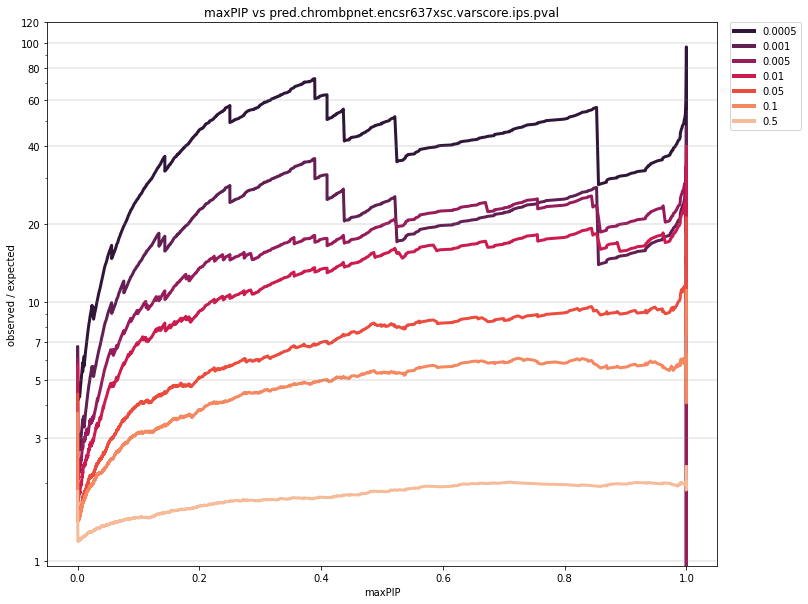

In [7]:
#0.0001
n_by_thresh_df = by_thresh_df
by_thresh_df = n_by_thresh_df[~n_by_thresh_df['thresh'].isin([0.0001])]

import matplotlib

import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

compare_score='maxPIP'
model_score='pred.chrombpnet.encsr637xsc.varscore.ips.pval'

ax = sns.lineplot(data=by_thresh_df, x='score', y='ratio', linewidth=3, ci=None,
                  hue='thresh', palette=sns.color_palette('rocket', 7))
leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for line in leg.get_lines():
    line.set_linewidth(4)
ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected')

ax.set(yscale='log')
ax.set_yticks([1,  3,  5, 7, 10, 20, 40, 60, 80, 100, 120])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axhline(y=1, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=3, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=5, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=7, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=10, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=20, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=40, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=60, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=80, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=100, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=120, color='grey', linestyle='-', alpha=0.2)


plt.savefig("subfigs/k562.atac.gwas.enrichment.pdf", transparent=True, dpi=300)

In [8]:
import numpy as np
import seaborn as sns


by_thresh_df = plot_enrichment_curves(data,
                       compare_score='obs.maxPIP', model_score='pred.chrombpnet.encsr000emt.varscore.ips.pval',
                       compare_score_ascending=False, model_score_ascending=True, output_file=None)

5890175
1002134
487006
94517
46388
8834
4209
811


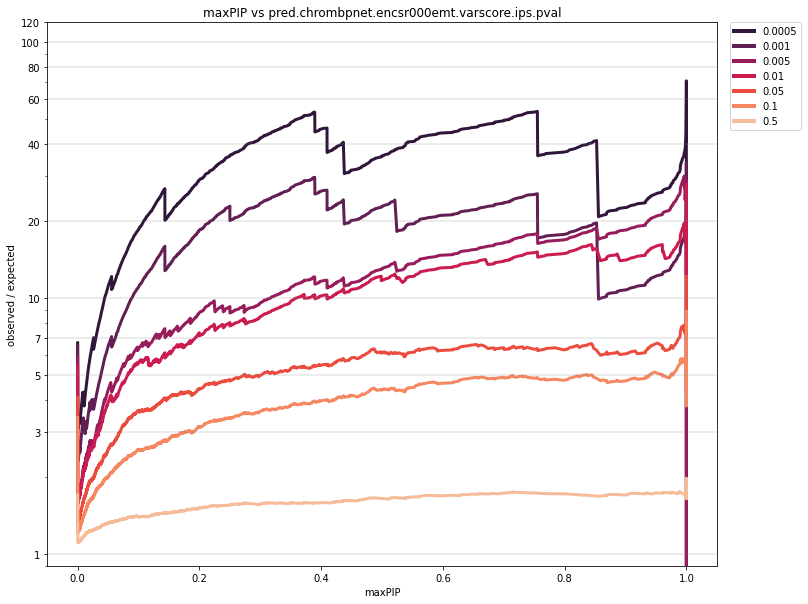

In [9]:
0.0001
n_by_thresh_df = by_thresh_df
by_thresh_df = n_by_thresh_df[~n_by_thresh_df['thresh'].isin([0.0001])]

import matplotlib

import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

compare_score='maxPIP'
model_score='pred.chrombpnet.encsr000emt.varscore.ips.pval'

ax = sns.lineplot(data=by_thresh_df, x='score', y='ratio', linewidth=3, ci=None,
                  hue='thresh', palette=sns.color_palette('rocket', 7))
leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for line in leg.get_lines():
    line.set_linewidth(4)
ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected')

ax.set(yscale='log')
ax.set_yticks([1,  3,  5, 7, 10, 20, 40, 60, 80, 100, 120])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axhline(y=1, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=3, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=5, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=7, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=10, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=20, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=40, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=60, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=80, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=100, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=120, color='grey', linestyle='-', alpha=0.2)

plt.savefig("subfigs/k562.dnase.gwas.enrichment.pdf", transparent=True, dpi=300)

In [10]:
data[data['obs.maxPIP']>0].shape

(12937, 17)

In [93]:
newdf = data[data['obs.maxPIP']>0.8].sort_values(['var.chr','var.pos_hg38'],ascending=False)

In [94]:
newdf

,var.chr,var.pos_hg38,var.allele1,var.allele3,obs.maxPIP,pred.chrombpnet.encsr637xsc.varscore.logfc,pred.chrombpnet.encsr637xsc.varscore.jsd,pred.chrombpnet.encsr637xsc.varscore.ips,pred.chrombpnet.encsr637xsc.varscore.ips.pval,pred.chrombpnet.encsr000emt.varscore.logfc,pred.chrombpnet.encsr000emt.varscore.jsd,pred.chrombpnet.encsr000emt.varscore.ips,pred.chrombpnet.encsr000emt.varscore.ips.pval,var.rsid,obs.traits,var.IDs,var.variant_id
7040055,chr9,132989049,C,G,0.995958,0.081857,0.028820,0.000653,0.064846,0.223039,0.072023,0.002342,0.020580,rs60757417,MCH|MCHC|MCV,MCH_rs60757417|MCHC_rs60757417|MCV_rs60757417,rs60757417
7040018,chr9,132985025,G,A,1.000000,-0.036393,-0.012325,0.001080,0.034151,-0.080289,-0.017216,0.001827,0.029560,rs73660574,MCH|MCV,MCH_rs73660574|MCV_rs73660574,rs73660574
6962539,chr9,113152303,C,T,0.948206,-0.059286,-0.013749,0.000648,0.042402,-0.071143,-0.025109,0.000723,0.069147,rs147707926,MCH|MCV,MCH_rs147707926|MCV_rs147707926,rs147707926
6956790,chr9,111901105,T,C,0.820901,-0.116446,-0.011068,0.001169,0.039519,0.095173,0.016358,0.000647,0.048397,rs148125759,MCH|MCV,MCH_rs148125759|MCV_rs148125759,rs148125759
6823692,chr9,82546215,A,G,0.873905,0.041083,0.008716,0.000015,0.548129,0.019713,0.009754,0.000009,0.485858,rs117133909,MCH|MCV,MCH_rs117133909|MCV_rs117133909,rs117133909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476925,chr1,117708521,C,T,1.000000,-0.100057,-0.014249,0.001188,0.026344,-0.188416,-0.021466,0.003636,0.018446,rs10923397,MCH|MCHC|MCV,MCH_rs10923397|MCHC_rs10923397|MCV_rs10923397,rs10923397
476924,chr1,117708466,G,T,0.999410,-0.048716,-0.012913,0.000837,0.043982,-0.059315,-0.016288,0.000767,0.064912,rs72695540,MCH,MCH_rs72695540,rs72695540
203022,chr1,50819789,A,G,0.999357,0.047908,0.006451,0.000014,0.575829,0.022881,0.005140,0.000005,0.514902,rs1972100,MCV,MCV_rs1972100,rs1972100
16153,chr1,3774964,A,G,0.999972,-0.048892,-0.016110,0.003072,0.038474,0.307188,0.030823,0.014740,0.004198,rs1175550,MCHC|MCV,MCHC_rs1175550|MCV_rs1175550,rs1175550


In [95]:
diff = newdf["var.pos_hg38"].diff()

In [96]:
mask = diff.abs() < 1000


In [97]:
sum(mask)

2

In [98]:
mask1 = mask.values
print(mask1)
mask2 = np.array(list(mask.values[1:])+[False])
print(mask.values[0:-1].shape)
mask = mask1+mask2

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True False False False]
(150,)


In [99]:
diff[mask]

476926   -40908623.0
476925         -32.0
476924         -55.0
Name: var.pos_hg38, dtype: float64

In [100]:
newdf.loc[mask,:]

,var.chr,var.pos_hg38,var.allele1,var.allele3,obs.maxPIP,pred.chrombpnet.encsr637xsc.varscore.logfc,pred.chrombpnet.encsr637xsc.varscore.jsd,pred.chrombpnet.encsr637xsc.varscore.ips,pred.chrombpnet.encsr637xsc.varscore.ips.pval,pred.chrombpnet.encsr000emt.varscore.logfc,pred.chrombpnet.encsr000emt.varscore.jsd,pred.chrombpnet.encsr000emt.varscore.ips,pred.chrombpnet.encsr000emt.varscore.ips.pval,var.rsid,obs.traits,var.IDs,var.variant_id
476926,chr1,117708553,A,C,1.00000,-0.095996,-0.017712,0.002985,0.011057,0.060584,0.021648,0.002167,0.024262,rs10923398,MCH|MCHC,MCH_rs10923398|MCHC_rs10923398,rs10923398
476925,chr1,117708521,C,T,1.00000,-0.100057,-0.014249,0.001188,0.026344,-0.188416,-0.021466,0.003636,0.018446,rs10923397,MCH|MCHC|MCV,MCH_rs10923397|MCHC_rs10923397|MCV_rs10923397,rs10923397
476924,chr1,117708466,G,T,0.99941,-0.048716,-0.012913,0.000837,0.043982,-0.059315,-0.016288,0.000767,0.064912,rs72695540,MCH,MCH_rs72695540,rs72695540


In [91]:
newdf.iloc[12615:,:]

,var.chr,var.pos_hg38,var.allele1,var.allele3,obs.maxPIP,pred.chrombpnet.encsr637xsc.varscore.logfc,pred.chrombpnet.encsr637xsc.varscore.jsd,pred.chrombpnet.encsr637xsc.varscore.ips,pred.chrombpnet.encsr637xsc.varscore.ips.pval,pred.chrombpnet.encsr000emt.varscore.logfc,pred.chrombpnet.encsr000emt.varscore.jsd,pred.chrombpnet.encsr000emt.varscore.ips,pred.chrombpnet.encsr000emt.varscore.ips.pval,var.rsid,obs.traits,var.IDs,var.variant_id
